# 5. Plots

**Some plots to obtain a quick impression of the data.**

## Libraries

In [1]:
library(tidyverse)

── Attaching packages ───────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ──────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Load final dataframe

In [2]:
adata <- readRDS(file = "data/result_df.rds")
glimpse(adata)

Rows: 10
Columns: 23
$ user_id             <dbl> 21788339, 21788339, 25816024, 36327895, 36327895, …
$ tweet_id            <chr> "911702953324457984", "911715368904691712", "91166…
$ createdAt           <dttm> 2017-09-23 23:24:57, 2017-09-24 00:14:17, 2017-09…
$ possiblySensitive   <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ source              <chr> "<a href=\"http://instagram.com\" rel=\"nofollow\"…
$ text                <chr> "Letzter Infostand in #Flensburg vor der #btw2017 …
$ isRetweet           <lgl> FALSE, FALSE, FALSE, TRUE, TRUE, TRUE, TRUE, TRUE,…
$ name                <chr> "Christian R.M. Lucks", "Christian R.M. Lucks", "G…
$ screenName          <chr> "crmkoch", "crmkoch", "GabiHillerOhm", "SoenkeRix"…
$ error               <chr> "Not Found Error", NA, "Not Found Error", "Not Fou…
$ in_reply_to_user_id <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA
$ lead1_dist          <dbl> 91, NA, NA, 112, 122, 121, 117, NA, 58, NA
$ lead2_dist          <dbl> NA, NA, NA, 1

## Descriptives

### Missing tweets

In [3]:
users_n <- adata %>% group_by(user_id) %>% summarize(n_tweets = n())
sum_tweets <- nrow(adata)
sum_del <- sum(adata$missing == 1)

not_found <- length(which(adata$error == "Not Found Error"))
unauth <- length(which(adata$error == "Authorization Error"))


errors <- adata %>% group_by(error) %>% summarise(n = n())
errors

print(paste0("Sum deleted: ", sum_del, " of ", sum_tweets, " (", round(sum_del/sum_tweets*100, digits =2),
            "%)"))

print(paste0("Sum not found: ", not_found, " (", round(not_found/nrow(adata)*100, digits =2), "%)"))
print(paste0("Sum unauthorized: ", unauth, " (", round(unauth/nrow(adata)*100, digits =2), "%)"))


print(paste("Number of users:", nrow(users_n)))

error,n
Not Found Error,8
NA,2


[1] "Sum deleted: 8 of 10 (80%)"
[1] "Sum not found: 8 (80%)"
[1] "Sum unauthorized: 0 (0%)"
[1] "Number of users: 4"


## Plots

### heavy tweeter

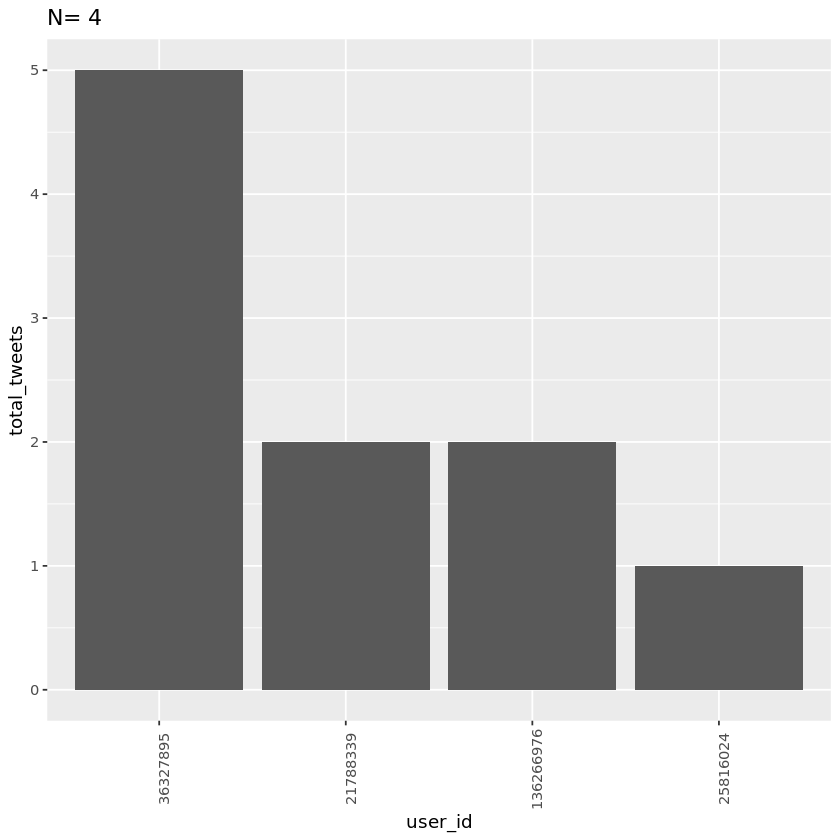

In [4]:
heavy_tweeter <- adata %>% 
    group_by(user_id) %>%
    summarise(total_tweets = n()) %>% 
    arrange(desc(total_tweets)) %>%
    slice(1:50)

ht <- ggplot(data = heavy_tweeter, 
             aes(x = reorder(user_id, -total_tweets), y = total_tweets)) +
    geom_col() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(x = "user_id", title = paste("N=", nrow(heavy_tweeter)))

ht

### heavy deleter (absolute)

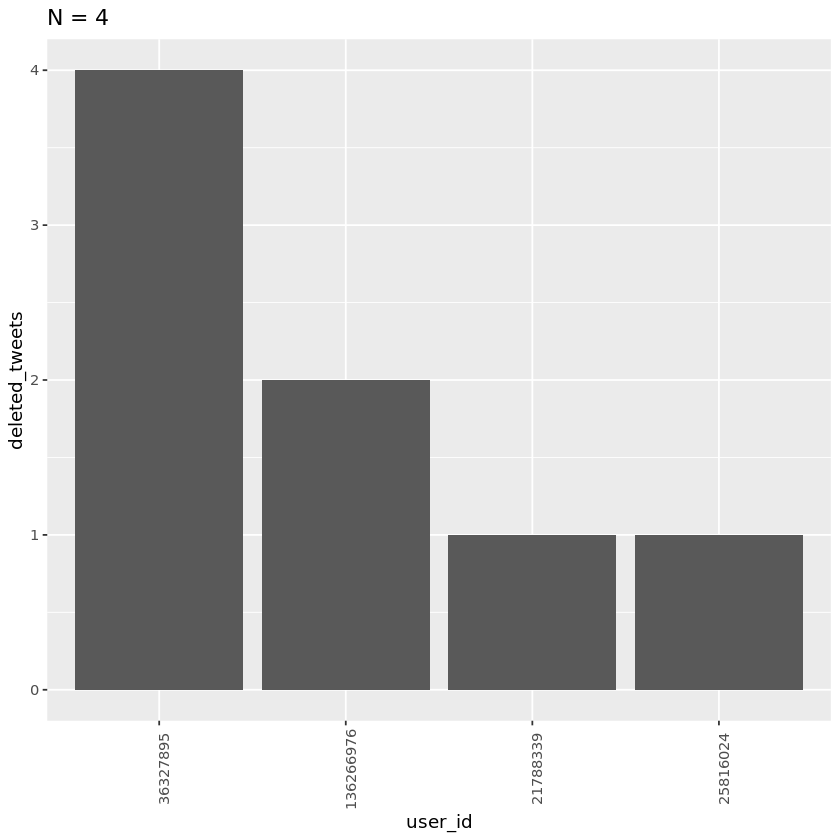

In [5]:
heavy_del_abs <- adata %>% 
    group_by(user_id) %>%
    summarise(deleted_tweets = sum(missing == 1)) %>% 
    arrange(desc(deleted_tweets)) %>%
    slice(1:50)

ht <- ggplot(data = heavy_del_abs, 
             aes(x = reorder(user_id, -deleted_tweets), y = deleted_tweets)) +
    geom_col() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(x = "user_id", title = paste("N =", nrow(heavy_del_abs)))

ht

### heavy deleter (relative)

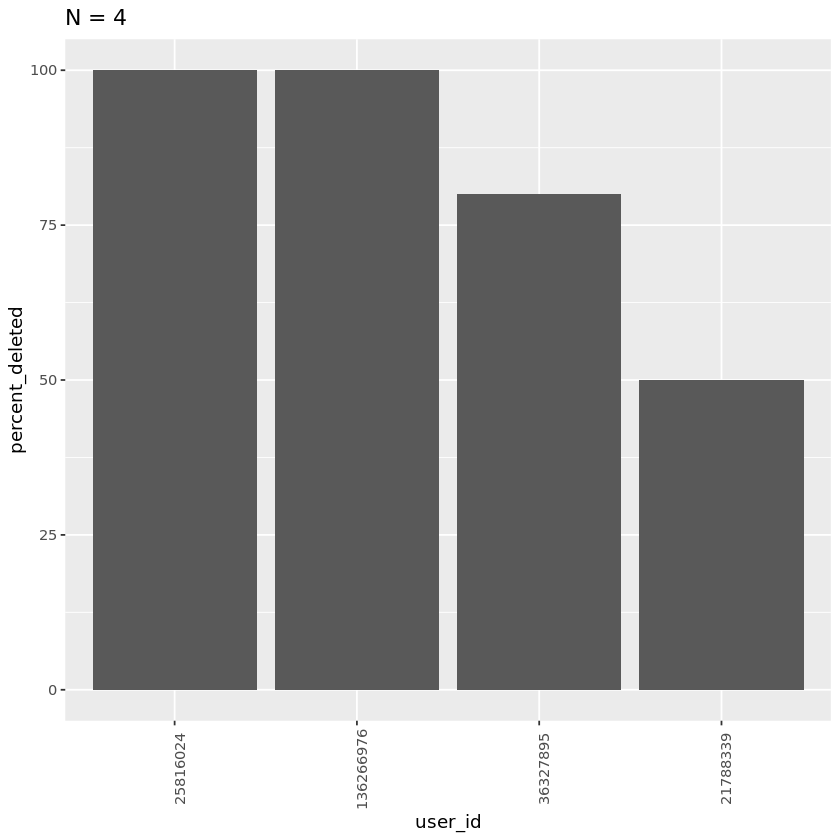

In [6]:
heavy_del_rel <- adata %>% 
    group_by(user_id) %>%
    summarise(total_tweets = n(),
              deleted_tweets = sum(missing == 1)) %>% 
    mutate(percent_deleted = round((deleted_tweets/total_tweets)*100, digits = 2)) %>%
    arrange(desc(percent_deleted)) %>%
    slice()

ht <- ggplot(data = heavy_del_rel, 
             aes(x = reorder(user_id, -percent_deleted), y = percent_deleted)) +
    geom_col() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(x = "user_id", title = paste("N =", nrow(heavy_del_rel)))

ht

## Timeline

### 1. All users

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`:
span is too small”

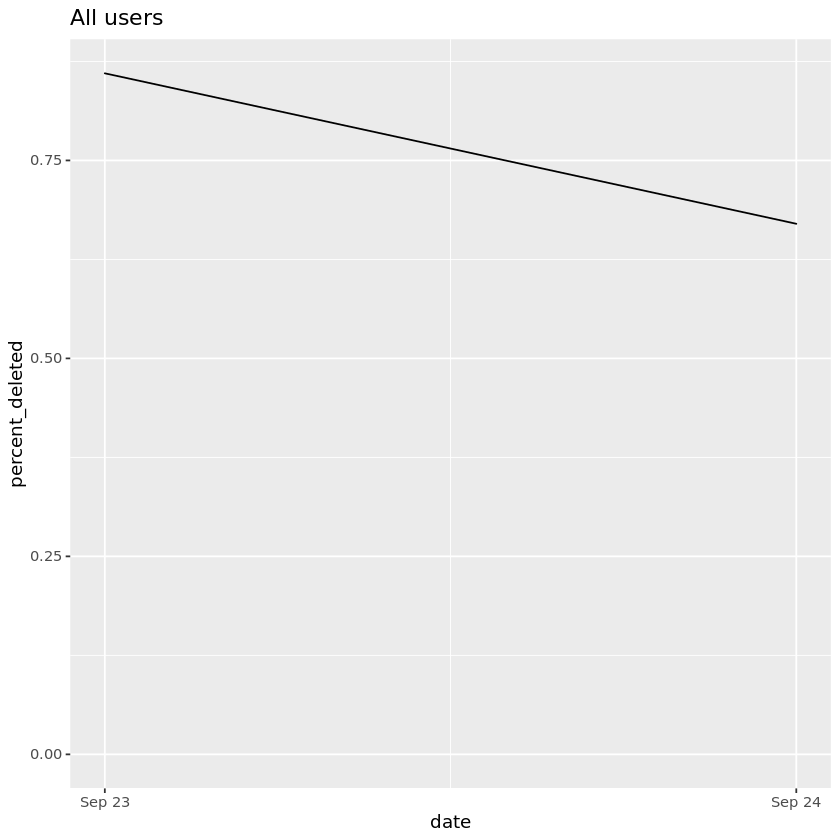

In [7]:
del_timeline <- adata %>%
    mutate(date = lubridate::as_date(createdAt)) %>%
    group_by(date) %>% 
    summarise(percent_deleted = round(mean(missing == 1), digits=2))
 
del_t <- ggplot(data = del_timeline,
                aes(x = date, y = percent_deleted)) +
                geom_smooth(span = 0.1, colour = "red") +
                geom_area(color="black", fill = "grey", alpha = 0) +
                labs(title = "All users")
        
del_t

### 2. Include selective deleters, exclude inactive users
- Selective deleters: percentage deleted tweets < 50%
- Inactive users: numer of tweets <= 10)
- Line gets smoother

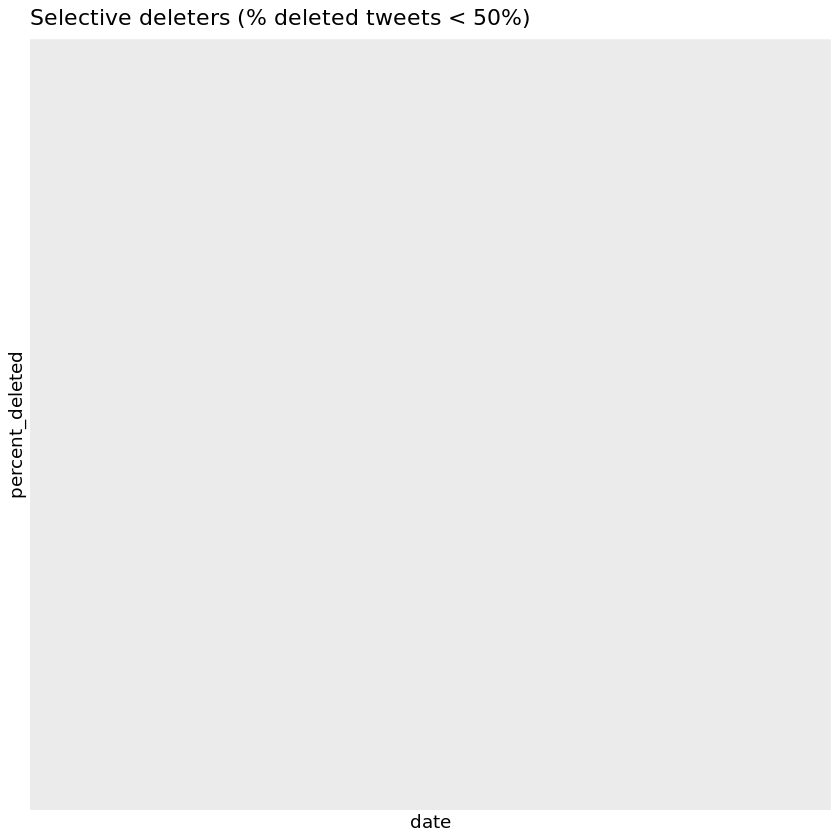

In [8]:
del_timeline <- adata %>% 
    dplyr::filter(usage != "inactive_user") %>%
    dplyr::filter(deletion_behaviour == "selective_deleter") %>%
    mutate(date = lubridate::as_date(createdAt)) %>%
    group_by(date) %>%
    summarise(percent_deleted = round(mean(missing == 1), digits=3))

del_t <- ggplot(data = del_timeline,
                aes(x = date, y = percent_deleted)) +
                geom_smooth(span = 0.1, colour = "red") +
                geom_area(color="black", fill = "grey", alpha = 0) +
                labs(title = "Selective deleters (% deleted tweets < 50%)")
        
del_t

### 3. Include selective keepers, exclude inactive users
- Selective keepers: percentage of deleted tweets > 50%
- Inactive users: numer of tweets <= 10)
- Larger peaks

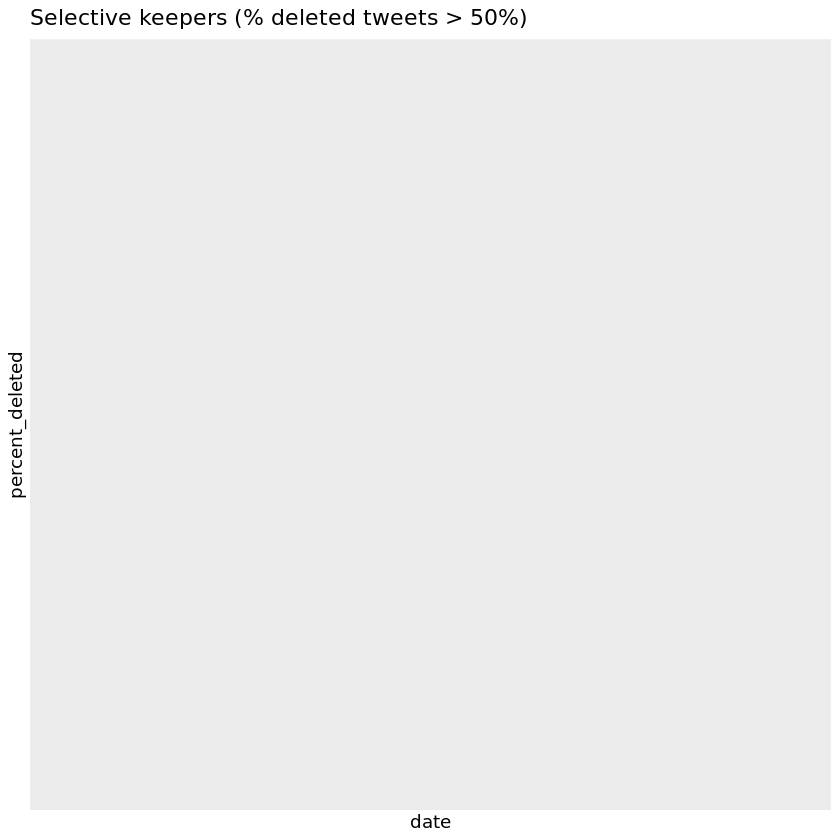

In [9]:
del_timeline <- adata %>% 
    dplyr::filter(usage != "inactive_user") %>%
    dplyr::filter(deletion_behaviour == "selective_keeper") %>%
    #table(del_timeline$screen_name) # about 45 accounts only
    mutate(date = lubridate::as_date(createdAt)) %>%
    group_by(date) %>%
    summarise(percent_deleted = round(mean(missing == 1), digits=3))


del_t <- ggplot(data = del_timeline,
                aes(x = date, y = percent_deleted)) +
                geom_smooth(span = 0.1, colour = "red") +
                geom_area(color="black", fill = "grey", alpha = 0) +
                labs(title = "Selective keepers (% deleted tweets > 50%)")
        
del_t